In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
print('packages loaded')

DATA_PATH = './homework_dataset/data_image_stitching/'
print('operating on data from: ', DATA_PATH)


packages loaded
operating on data from:  ./homework_dataset/data_image_stitching/


In [166]:
""" 
generates a list of file directories from a given prefix, number of files, and file type
prefix: prefix of the file name
number_of_files: number of files to read (will be concatenated with the prefix)
file_type: type of the file to read
"""
def generate_test_file_directories(prefix, number_of_files, file_type='jpg'):
    files = []
    for i in range(1, number_of_files+1):
        files.append(DATA_PATH + prefix + str(i) + '.' + file_type)
    return files
        
dirs = generate_test_file_directories('im2_', 4, 'jpg')
print(dirs)
    

['./homework_dataset/data_image_stitching/im2_1.jpg', './homework_dataset/data_image_stitching/im2_2.jpg', './homework_dataset/data_image_stitching/im2_3.jpg', './homework_dataset/data_image_stitching/im2_4.jpg']


In [167]:
"""
generates a list of cv2 images from a list of file directories
files: list of file directories
"""
def generate_cv2_images_from_files(files):
    images = []
    for file in files:
        images.append(cv2.imread(file))
    return images

images = generate_cv2_images_from_files(dirs)
print(images[0].shape)

(648, 972, 3)


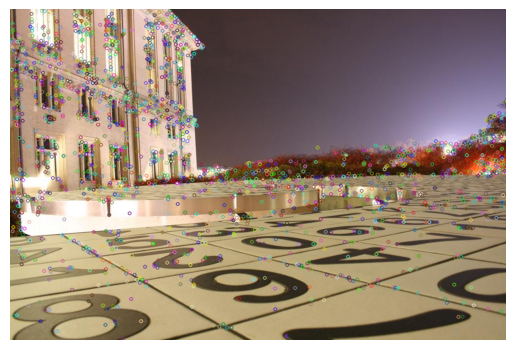

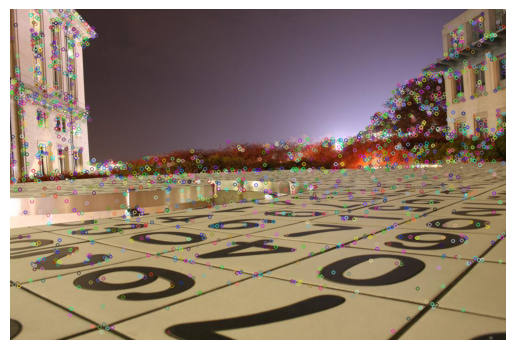

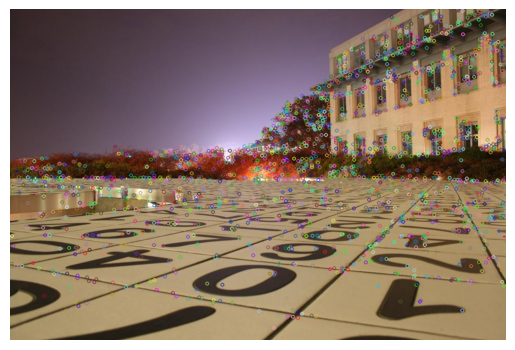

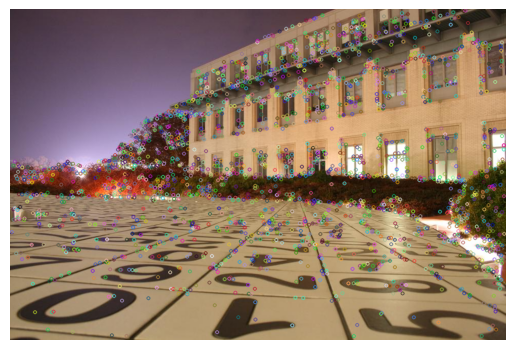

In [168]:
""" 
computes the sift features of a list of images
images: list of images
"""
def compute_sift_features(images):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for image in images:
        kp, des = sift.detectAndCompute(image, None)
        keypoints.append(kp)
        descriptors.append(des)
    return keypoints, descriptors

keypoints, descriptors = compute_sift_features(images)
#display sift features on image
for i in range(len(images)):
    #convert image to rgb
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    img = cv2.drawKeypoints(images[i], keypoints[i], None)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    

In [169]:
# Define a function to compute the Euclidean distance between two vectors
def euclidean_distance(v1, v2):
    # Compute and return the Euclidean distance between two vectors
    return np.sqrt(np.sum((v1 - v2)**2))

# Define a function to find the matches between two SIFT descriptors using NNDR
def find_matches(desc1, desc2, threshold):
    # Initialize an empty list to store the matches
    matches = []
    # Loop through each feature in the first descriptor
    for i, f1 in tqdm(enumerate(desc1), total=len(desc1), desc='Finding matches'):
        # Initialize two variables to store the nearest and second nearest distances
        nearest_dist = float('inf')
        second_nearest_dist = float('inf')
        # Initialize a variable to store the index of the nearest feature in the second descriptor
        nearest_index = -1
        # Loop through each feature in the second descriptor
        for j, f2 in enumerate(desc2):
            # Compute the Euclidean distance between the two features
            dist = euclidean_distance(f1, f2)
            # Update the nearest and second nearest distances and index if necessary
            if dist < nearest_dist:
                second_nearest_dist = nearest_dist
                nearest_dist = dist
                nearest_index = j
            elif dist < second_nearest_dist:
                second_nearest_dist = dist
        # Compute the NNDR ratio
        ratio = nearest_dist / second_nearest_dist
        # If the ratio is below the threshold, add the match to the list
        if ratio < threshold:
            matches.append((i, nearest_index))
    # Return the list of matches
    return matches

# Define a method to draw the matched points using cv2
def draw_matches(img1, img2, kp1, kp2, matches):
    # Create a new image to display the matches
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img3 = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    img3[:h1, :w1] = img1
    img3[:h2, w1:] = img2
    # Loop through each match
    for i, j in matches:
        # Get the coordinates of the matched keypoints
        x1, y1 = kp1[i].pt
        x2, y2 = kp2[j].pt
        # Draw a line and a circle for each match
        cv2.line(img3, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (0, 255, 0), 1)
        cv2.circle(img3, (int(x1), int(y1)), 2, (0, 0, 255), -1)
        cv2.circle(img3, (int(x2) + w1, int(y2)), 2, (0, 0, 255), -1)
    # Return the image with the matches
    return img3

desc_1, desc_2 = descriptors[0], descriptors[1]
kp_1, kp_2 = keypoints[0], keypoints[1]
img_1, img_2 = images[0], images[1]
matched_features = find_matches(desc_1, desc_2, 0.6)
print(len(matched_features))
#matched_features_in_dmatch = prepare_matches_for_drawing(matched_features)
matched_features_img = draw_matches(img_1, img_2, kp_1, kp_2, matched_features)
#matched_features_img = cv2.drawMatches(img_1, kp_1, img_2, kp_2, matched_features_in_dmatch, img_1, flags=2)
plt.imsave('matched_features.png', matched_features_img)
#matches_ransac, p1_all, p2_all = convert_matches_for_ransac(kp_1, kp_2, matched_features_in_dmatch)

Finding matches: 100%|██████████| 2245/2245 [00:31<00:00, 71.48it/s]


545


Number of inliers:  495


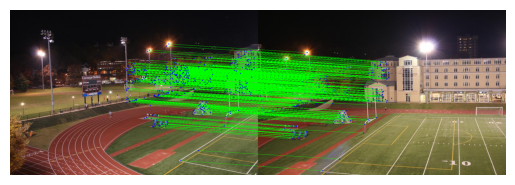

Homography matrix:  [[ 1.32112396e+00  2.02868950e-02 -5.93882853e+02]
 [ 9.42855731e-02  1.21907539e+00 -1.95527704e+01]
 [ 3.33944812e-04 -2.44397027e-05  1.00000000e+00]]


In [164]:
import random
def compute_homography(src_pts, dst_pts):
    # convert the points to homogeneous coordinates
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    src_pts = np.append(src_pts, np.ones((len(src_pts), 1)), axis=1)
    dst_pts = np.append(dst_pts, np.ones((len(dst_pts), 1)), axis=1)

    # construct the matrix A from the point correspondences
    A = []
    for i in range(len(src_pts)):
        x, y, z = src_pts[i]
        u, v, w = dst_pts[i]
        A.append([0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z])
        A.append([w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z])
    A = np.array(A)

    # compute the singular value decomposition of A
    U, S, V = np.linalg.svd(A)

    # the homography matrix is the last column of V
    H = V[-1].reshape(3, 3)

    # normalize the homography matrix
    H = H / H[2, 2]

    # return the homography matrix
    return H

# Define a function to compute the symmetric transfer error between two sets of points and a homography matrix
def compute_error(p1, p2, H):
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    # convert the points to homogeneous coordinates
    p1 = np.append(p1, np.ones((len(p1), 1)), axis=1)
    p2 = np.append(p2, np.ones((len(p2), 1)), axis=1)
    
    #transform the points from the first image to the second image
    p1_transformed = np.dot(H, p1.T).T
    #normalize the transformed points
    p1_transformed = p1_transformed / p1_transformed[:, 2].reshape(-1, 1)
    
    #transform the points from the second image to the first image
    p2_transformed = np.dot(np.linalg.inv(H), p2.T).T
    #normalize the transformed points
    p2_transformed = p2_transformed / p2_transformed[:, 2].reshape(-1, 1)
    
    #compute the symmetric transfer error
    error = np.sum((p1_transformed[:, :2] - p2[:, :2])**2, axis=1) + np.sum((p2_transformed[:, :2] - p1[:, :2])**2, axis=1)
    
    #return the error
    return error

# Define a function to find the inliers using RANSAC algorithm
def find_inliers(kp1, kp2, matches, threshold, n_iter):
    # Initialize an empty list to store the inliers
    inliers = []
    # Initialize a variable to store the maximum number of inliers
    max_inliers = 0
    # Initialize a variable to store the best homography matrix
    best_H = None
    # Loop through the iterations
    for i in range(n_iter):
        # Randomly select four matches
        sample = random.sample(matches, 4)
        # Get the coordinates of the matched keypoints
        p1 = np.array([kp1[i].pt for i, j in sample])
        p2 = np.array([kp2[j].pt for i, j in sample])
        # Compute the homography matrix using the sample points
        H = compute_homography(p1, p2)
        # Get the coordinates of all the matched keypoints
        p1 = np.array([kp1[i].pt for i, j in matches])
        p2 = np.array([kp2[j].pt for i, j in matches])
        # Compute the error for all the matches
        error = compute_error(p1, p2, H)
        # Find the matches that have error below the threshold
        inliers_i = [match for match, e in zip(matches, error) if e < threshold]
        # Count the number of inliers
        n_inliers = len(inliers_i)
        # Update the inliers, the maximum number of inliers and the best homography matrix if necessary
        if n_inliers > max_inliers:
            inliers = inliers_i
            max_inliers = n_inliers
            best_H = H
    # Return the inliers and the best homography matrix
    return inliers, best_H

inliers, H = find_inliers(kp_1, kp_2, matched_features, 1, 1000)
print('Number of inliers: ', len(inliers))
ransac_img = draw_matches(img_1, img_2, kp_1, kp_2, inliers)
plt.imshow(ransac_img)
plt.axis('off')
#plt.title('Inliers from RANSAC: ' + str(len(inliers)) + ' out of ' + str(len(matched_features)))
plt.show()

print('Homography matrix: ', H)

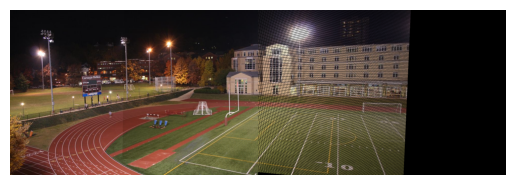

In [165]:
def switch_orientation_as_matrix(image):
    rows, cols, depth = image.shape
    matrix = np.zeros((cols, rows, depth), dtype='int32')
    for i in range(rows):
        matrix[:,i] = image[i]
    
    return matrix

def switch_orientation_as_img(matrix):
    cols, rows, depth = matrix.shape
    image = np.zeros((rows, cols, depth), dtype='int32')
    for i in range(cols):
        image[:,i] = matrix[i]
        
    return image

def warp_perspective(image, homography, dim):
    m_image = switch_orientation_as_matrix(image)
    r, c = dim
    m_dest_image = np.zeros((r, c, m_image.shape[2]))
    for i in range(m_image.shape[0]):
        for j in range(m_image.shape[1]):
            x, y = get_transformed_point(homography, i, j)
            if is_in_borders(x, r) and is_in_borders(y, c):
                m_dest_image[x, y] = m_image[i, j]
    
    return switch_orientation_as_img(m_dest_image)

def is_in_borders(point, border_limit):
    return point >= 0 and point < border_limit

def get_transformed_point(homography, x, y):
    mapped_point = np.dot(homography, [x, y, 1])
    x, y, _ = (mapped_point / mapped_point[2] + 0.5).astype(int) 
    return x, y

def alpha_blending(alpha, pix1, pix2):
    return (1-alpha)*pix1 + alpha*pix2

def transfer_image_with_alpha_blending(img_to_copy, dest_img):
    alphas = np.linspace(0, 1, img_to_copy.shape[1])
    m_img_to_copy = switch_orientation_as_matrix(img_to_copy)
    m_dest_img = switch_orientation_as_matrix(dest_img)

    for i in range(m_img_to_copy.shape[0]):
        for j in range(m_img_to_copy.shape[1]):
            if m_dest_img[i, j].all() == 0:
                m_dest_img[i, j] = m_img_to_copy[i, j]
            else:
                m_dest_img[i, j] = alpha_blending(alphas[j], m_img_to_copy[i, j], m_dest_img[i, j])
    
    return switch_orientation_as_img(m_dest_img)

#stitched_image = cv2.warpPerspective(img_2, np.linalg.inv(H), (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))
warped_image = warp_perspective(img_2, np.linalg.inv(H),  (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))

final_img = transfer_image_with_alpha_blending(img_1, warped_image)
float_img = final_img.astype(np.float32)/255
plt.imshow(float_img)
plt.axis('off')
plt.show()